# Network Formation Games


In [224]:
import networkx as nx
import matplotlib.pyplot as plt
import random 
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import collections

In [225]:
def initEmptyGraph(N):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i, value=0)
    return G

def createGraph(emptyGraph, p):
    G = emptyGraph
    for node in tqdm(list(G.nodes)):
        for n in list(G.nodes):
            if  n != node and random.uniform(0.0, 1.0) < p:
                G.add_edge(node,n)
    return G

def getSizeLargestComponent(G):
    return len(max(nx.connected_components(G), key=len))

def getSizeLargestClique(G):
    return nx.approximation.large_clique_size(G)

100%|██████████| 100/100 [00:00<00:00, 15697.25it/s]


Taille du plus grand groupe de noeuds interconnecté : 74 (74.0%)
Taille de la plus grande clique : 2 (2.0%)


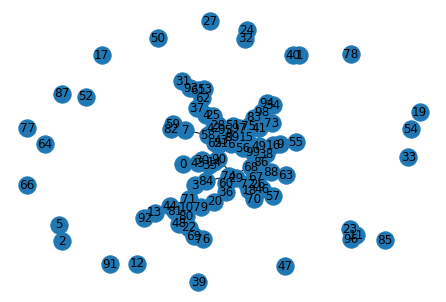

In [226]:
p = 0.01
N = 100

emptyG = initEmptyGraph(N)
G = createGraph(emptyG, p)

largest_component = getSizeLargestComponent(G)
pourcentage_component = ((largest_component)/N)*100

largest_clique = getSizeLargestClique(G)
pourcentage_clique = ((largest_clique)/N)*100

nx.draw(G,with_labels=True)
print(f"Taille du plus grand groupe de noeuds interconnecté : {largest_component} ({pourcentage_component}%)")
print(f"Taille de la plus grande clique : {largest_clique} ({pourcentage_clique}%)")

En utilisant nos propres fonctions pour créer les graphes, les temps d'execution sont beaucoup trop élevés pour générer les 100 graphes. 

On décide donc d'utiliser les fonctions natives plus optimisées de NetworkX.

In [227]:
probabilities = []
largest_components = []
largest_cliques = []


for p in tqdm(np.arange(0.001, 1, 0.001)):
    G = nx.gnp_random_graph(100, p)
    probabilities.append(p)
    largest_components.append(getSizeLargestComponent(G))
    largest_cliques.append(getSizeLargestClique(G))
df = pd.DataFrame(zip(probabilities,largest_components,largest_cliques), columns=['Probability', 'Largest component size', 'Largest clique size'])
fig = px.bar(df, x='Probability', y='Largest component size')
fig.show()
fig = px.bar(df, x='Probability', y='Largest clique size')
fig.show()


100%|██████████| 999/999 [00:53<00:00, 18.82it/s] 


## Degree Distribution for a probability of 0.99

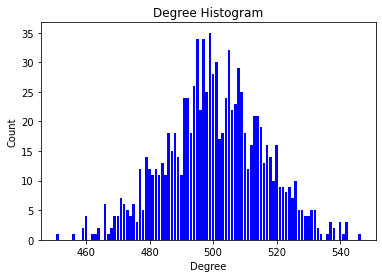

In [294]:
G = nx.gnp_random_graph(1000, 0.5)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

# 2- Simple graph formation game

In [295]:
def compute_values(G, error=1):
    nodes = G.nodes
    for node in nodes:
        value = 0
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 1:
            value = 1
        else:
            for neighbor in neighbors:
                value += G.nodes[neighbor]['value']
        G.nodes[node]['value'] = value * error       

In [296]:
def simpleGraphFormation(N, inf=1, sup=1):
    G = initEmptyGraph(N)
    nodes = list(G.nodes)
    random.shuffle(nodes)
    for node in nodes:
        compute_values(G, random.uniform(inf, sup))
        values = nx.get_node_attributes(G, 'value')
        values.pop(node)
        max_value_node = max(values.items(), key=lambda n : n[1])
        if max_value_node[1] == 0:
            G.add_edge(node, random.randint(0, 100))
        else:
            G.add_edge(node, max_value_node[0])
    return G

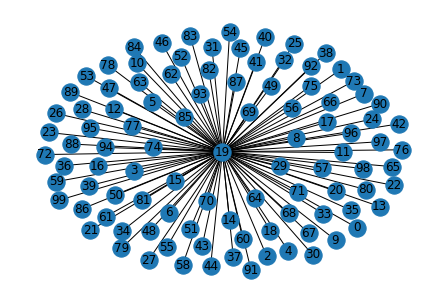

In [297]:
G = simpleGraphFormation(100)
nx.draw(G, with_labels=True)

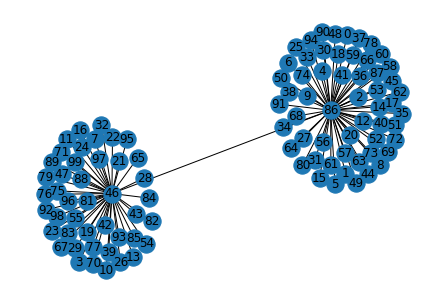

In [332]:
G = simpleGraphFormation(100, 0.3, 1.7)
nx.draw(G, with_labels=True)